<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2022

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 3 <br>
American Sign Language Image Classification
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
			<br/><br/>
Deadline:  
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
<br>
<font size=3 color=grey>
Author: Sayeh Jarollahi
</font>
                <br/>
    </div>

In [11]:
# Set your student number
student_number = 99101319
Name = 'Mohamadreza'
Last_Name = 'Pirpiran'

In this question, you will train a neural network for classifying sign language images. The American  Sign Language (ASL) dataset consists of 2515 images from different numbers and alphabets. The images are in RGB format and are not the same size. The dataset is classified into 36 classes (10 numbers and 26 alphabets). 

You will need to train a model to classify this dataset into different categories. You are allowed to use MLP as well as CNN networks. 

**Grading Policy:** For a full mark on this assignment, your notebook should be completely runnable by the TA. Additionally, you must reach an accuracy of %96 on the test data.

It is highly recommended to use google colab and utilize its GPUs. However, if you want to run the notebook locally, you can reach and download the dataset in this [link](https://drive.google.com/file/d/11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5/view?usp=share_link).



## Setup


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from IPython.display import clear_output
import seaborn as sns

import torch
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn


In [13]:
def get_files(main_dir='asl_dataset/asl_dataset'):
    files_addr , lbls = [], []
    for dir in os.listdir(main_dir):
        lbl = int(dir) if dir.isdigit() else (ord(dir) - 87)
        addrs = [f'{main_dir}/{dir}/{file_name}' for file_name in os.listdir(f'{main_dir}/{dir}')]
        files_addr.extend(addrs)
        lbls.extend([lbl]*len(addrs))
    return files_addr, lbls

In [14]:
# NOTE: It is highly recommended to use colab GPUs!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Download and unzip the dataset


In [15]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11_4-N8EdtoLPiW3YyJ840CXM0FckO1e5" -O asl_dataset.zip && rm -rf /tmp/cookies.txt
! unzip asl_dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: asl_dataset/0/hand2_0_dif_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0

In [16]:
main_dir = "asl_dataset/asl_dataset"
class_dirs = os.listdir(main_dir)

## Transform 

Data transformation is the process of converting data from one format or structure into another format or structure. Transformers change pixel values but still keep almost the whole information of the image.[source](https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4) You can read more about them in the mentioned source. 

You are going to implement two different transformers from scratch. These transformers will be used once the data is loaded. 

### Resize 
This transformer recieves a tensor (3\*x\*y) and returns a tensor with shape (3\*size\*size)

In [17]:
class Resize(object):
    
    def __init__(self, size=64):
      self.size = size
      pass
    
    
  
    def __call__(self, x):
        '''
        This function recieves a tensor and applies the resizing on that and returns that tensor
        '''
        x = transforms.Resize(self.size).forward(x)
        return x

### GrayScale
This transform is helpful to decrease the number of channels, so the training gets faster. 

Feel free to add args to functions or change them if you need to!

In [18]:
class GrayScale(object):

    def __init__(self, number_of_channels = 3):
      self.number_of_channels = number_of_channels
      pass

    def __call__(self,x):
      x = transforms.Grayscale(self.number_of_channels).forward(x)
      return x

## Load Data and compose transforms 
You can combine Transforms using the **compose** method in the torchvision.transforms library.

In [19]:
# Ddd the implemented transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    Resize(),
    GrayScale()
])

Plot one random sample from each class of the datset:

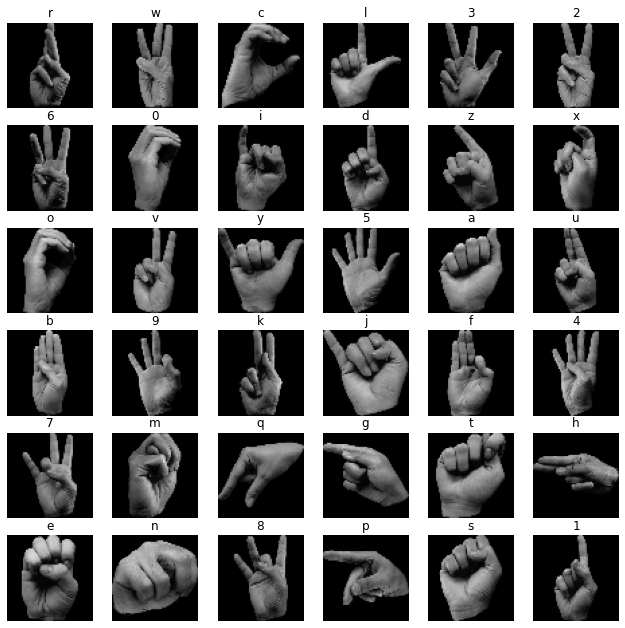

In [20]:
'''
Hint:
Get two random samples from files in each directory and use subplot to add those
images to the plot. 
Use previously defined transform to test your transforms
'''
fig = plt.figure(figsize=(11,11))
row = 6
columns = 6
for i, directory in enumerate(class_dirs):
    # name of all files in the directory
    files_name = os.listdir(f"{main_dir}/{directory}")
    random_number = random.randint(0,len(files_name))
    image = cv2.imread(main_dir + "/" + directory + "/" + files_name[random_number])
    image = transform(image)
    fig.add_subplot(row,columns,i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(directory)
    
    
    


## Create Dataset 
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. [from [Pytorch Documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)] 

In this section, you will implement a custom dataset which gets address of files and loads them as needed. 

In [21]:
class ASLDataset(Dataset):
    def __init__(self, files_address:list, labels:list, transform=transform):
        self.transform = transform
        self.files_address = files_address
        self.labels = labels
        pass

    def __len__(self):
        # returns length of the data
        return len(self.files_address)

    def __getitem__(self, idx):
        # Hint: load image from files_address and the label from name of the directory 
        # Remember to apply transforms!
        image = image = Image.open(self.files_address[idx])
        image = transform(image)
        image = torch.div(image, 0.5)
        label = self.labels[idx]
        return image, label

In [22]:
files_addr, labels = get_files()
print(len(labels), len(files_addr))

2515 2515


## Create Datasets  

First split data to train, validation and test using the `train_test_split funciton`. Remember to shuffle data. Then create ASLDataset for each part of data. 

In [23]:
x_train, x_test, y_train, y_test = train_test_split(files_addr, labels, test_size= 19, shuffle = True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=128, shuffle = True)

train_dataset = ASLDataset(files_address = x_train,labels = y_train)
val_dataset = ASLDataset(files_address = x_val,labels = y_val)
test_dataset = ASLDataset(files_address = x_test,labels = y_test)
print(len(train_dataset),len(val_dataset),len(test_dataset))

2368 128 19


Use datasets to create DataLoader from `torch.utils.DataLoader` class

Note: You should make `shuffle=True` for the training dataLoader, so in each epoch the data reshuffles. 

In [24]:
num_threads = 4
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader),len(val_loader),len(test_loader))

74 4 1


## Define Model 

In [25]:
class ASLModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = nn.Sequential(
          
              nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
              nn.ReLU(),
              nn.Conv2d(16,32, kernel_size = 3, stride = 1, padding = 1),
              nn.ReLU(),
              nn.MaxPool2d(3,3),
          
              nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
              nn.ReLU(),
              nn.Conv2d(32 ,64, kernel_size = 3, stride = 1, padding = 1),
              nn.ReLU(),
              nn.MaxPool2d(3,3),
              nn.BatchNorm2d(64),
              
              
              nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
              nn.ReLU(),
              nn.Conv2d(128,256, kernel_size = 3, stride = 1, padding = 1),
              nn.ReLU(),
              nn.MaxPool2d(3,3),

              nn.BatchNorm2d(256),
              
              nn.Flatten(),
              nn.Dropout(0.5),
              nn.Linear(1024,512),
              nn.ReLU(),
              nn.Linear(512,36),
               
            )
        
    def forward(self, xb):
        return F.log_softmax(self.network(xb), dim=1)


In [56]:
torch.manual_seed(0)
learning_rate = 0.001
loss_function = nn.NLLLoss()
model = ASLModel(in_channels = 3,num_classes =  36).to(device)
print(sum(p.numel() for p in model.parameters()))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-04)


945764


## Define optimizer, Criterion and other parameters 


In [57]:
best_model = None
best_acc = 0
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_val (model, trainloader, val_loader, f_loss, optimizer, n_epochs, device = device):
    best_acc = 0
    train_loss_arr, val_loss_arr = [], []
    train_acc_arr, val_acc_arr = [], []  
    for epoch in range(n_epochs):
        train_loss, val_loss = 0, 0
        model.train()
        #############################
        #         Code here         #
        #############################
        ## Hint: Loop throught train_loader, get images with their labels and train the model
        ## Hint 2: To update train_loss inside the loop use "train_loss += batch_loss * batch_size""
        ## Hint 3: To update train_acc get the predicted label of each training data and compare with the real label
        train_batch_accs = []
        for image_batch in trainloader:
          images,real_labels = image_batch
          images,real_labels = images.to(device),real_labels.to(device)
          predc_labels = model(images)
          loss = f_loss(predc_labels,real_labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss += loss * batch_size
          batch_acc = accuracy(predc_labels,real_labels)
          train_batch_accs.append(batch_acc)
          


    
        model.eval()
        #############################
        #         Code here         #
        #############################
        ## Hint: Loop throught val_loader, get images with their labels and evaluate the model
        ## Hint 2: To update val_loss inside the loop use "val_loss += batch_loss * batch_size""
        ## Hint 3: you have to keep the best model in the best_model variable to use it in the testing phase
        val_batch_accs = []
        with torch.no_grad():
          for image_batch in val_loader:
            images,real_labels = image_batch
            images,real_labels = images.to(device),real_labels.to(device)
            predc_labels = model(images)
            loss = f_loss(predc_labels,real_labels)
            val_loss += loss * batch_size
            batch_acc = accuracy(predc_labels,real_labels)
            val_batch_accs.append(batch_acc)
        if (torch.stack(val_batch_accs).mean() > best_acc):
          best_acc = torch.stack(val_batch_accs).mean()
          best_model = model
        
          
        

        

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_loss_arr.append(train_loss)
        val_loss_arr.append(val_loss)
        #############################
        #         Code here         #
        #############################
        # append accuracy of train and valid to the lists
        val_acc_arr.append(torch.stack(val_batch_accs).mean())
        train_acc_arr.append(torch.stack(train_batch_accs).mean())

        print(f"[Epoch {epoch}]\t"
            f"Train Loss: {train_loss:.3f}\t"
            f"Validation Loss: {val_loss:.3f}")
        print("train accuracy : ",torch.stack(train_batch_accs).mean()," val accuracy : ",torch.stack(val_batch_accs).mean())
        
    return train_loss_arr, val_loss_arr, train_acc_arr, val_acc_arr

In [58]:
# Call the train_val function
train_loss_arr,val_loss_arr,train_acc_arr,val_acc_arr = train_val(model = model,trainloader = train_loader,val_loader=val_loader,f_loss = loss_function,optimizer = optimizer,n_epochs=30)

[Epoch 0]	Train Loss: 1.164	Validation Loss: 0.478
train accuracy :  tensor(0.6495)  val accuracy :  tensor(0.8672)
[Epoch 1]	Train Loss: 0.294	Validation Loss: 0.284
train accuracy :  tensor(0.8974)  val accuracy :  tensor(0.9062)
[Epoch 2]	Train Loss: 0.220	Validation Loss: 0.151
train accuracy :  tensor(0.9261)  val accuracy :  tensor(0.9453)
[Epoch 3]	Train Loss: 0.144	Validation Loss: 0.142
train accuracy :  tensor(0.9464)  val accuracy :  tensor(0.9688)
[Epoch 4]	Train Loss: 0.110	Validation Loss: 0.116
train accuracy :  tensor(0.9616)  val accuracy :  tensor(0.9688)
[Epoch 5]	Train Loss: 0.059	Validation Loss: 0.075
train accuracy :  tensor(0.9785)  val accuracy :  tensor(0.9688)
[Epoch 6]	Train Loss: 0.079	Validation Loss: 0.095
train accuracy :  tensor(0.9734)  val accuracy :  tensor(0.9688)
[Epoch 7]	Train Loss: 0.052	Validation Loss: 0.041
train accuracy :  tensor(0.9848)  val accuracy :  tensor(0.9844)
[Epoch 8]	Train Loss: 0.040	Validation Loss: 0.045
train accuracy :  ten

## Plot loss and accuracy

You must have one plot for loss according to epoch for train/val.

Also, another plot for accuracy according to epoch for train/val

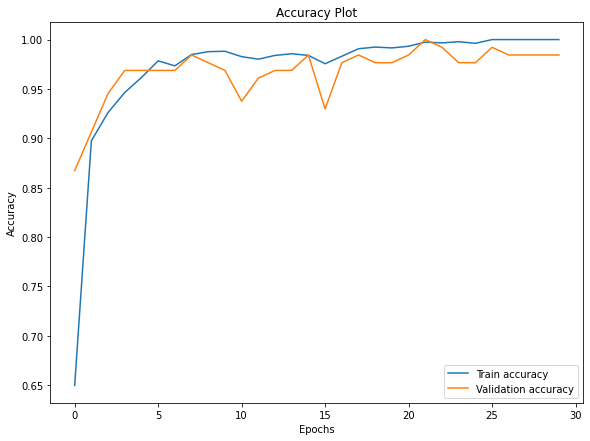

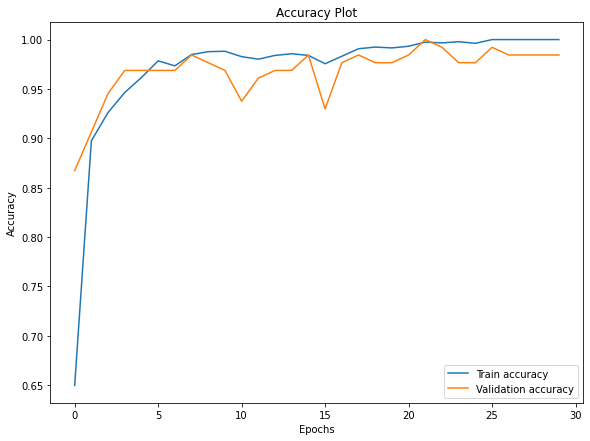

In [60]:
#############################
#         Code here         #
#############################

plt.subplots(figsize=(21,7))

# loss = plt.subplot(1, 2, 1)
# loss.set_title('Loss Plot')
# loss.set_xlabel('Epochs')
# loss.set_ylabel('Loss')
# loss.plot(train_loss_arr)
# loss.plot(val_loss_arr)
# loss.legend(['Train loss', 'Validation loss'])

accuracay = plt.subplot(1, 2, 2)
accuracay.set_title('Accuracy Plot')
accuracay.set_xlabel('Epochs')
accuracay.set_ylabel('Accuracy')
accuracay.plot(train_acc_arr)
accuracay.plot(val_acc_arr)
accuracay.legend(['Train accuracy', 'Validation accuracy'])

plt.show()

## Evaluate model on the test dataset

Evaluate your best model on the test dataset. You should get accuracy above ***%96*** for a full-mark.

Remember to print the accuracy of model on the test dataset! 

Test F1-score: 1.0000
Test Accuracy: 100.00%


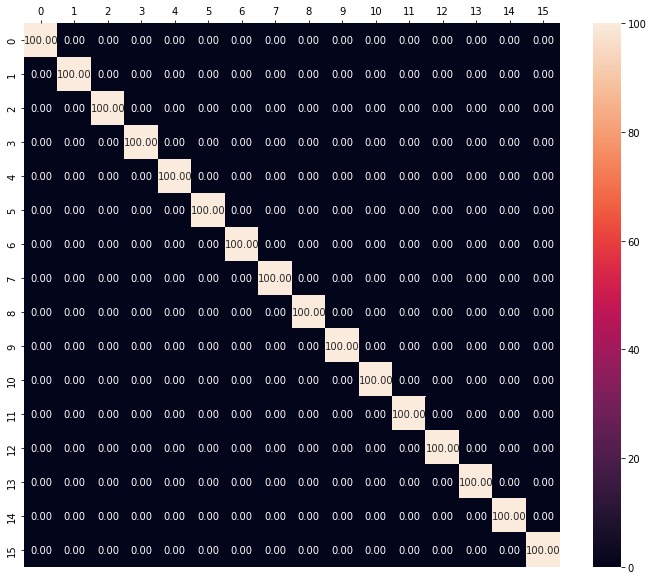

In [61]:
#############################
#         Code here         #
#############################
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        pred = model(images).argmax(dim=1, keepdim=True)
        
        accuracy = accuracy_score(labels.detach().cpu().numpy(), pred.detach().cpu().numpy())
        f1 = f1_score(labels.detach().cpu().numpy(), pred.detach().cpu().numpy(), average='macro')
        confusion = confusion_matrix(labels.detach().cpu().numpy(), pred.detach().cpu().numpy(), normalize='true')
        
        plt.figure(figsize=(12,10))
        print(f'Test F1-score: {f1:.4f}')
        print(f'Test Accuracy: {accuracy * 100:.2f}%')
        
        ax = sns.heatmap(confusion * 100, annot=True, fmt='.2f')
        ax.xaxis.tick_top()